# Cornell Weather Data

### By Tony Oh (do256) and Sennet Senadheera (sas639)

Our project will attempt to predict Cornell’s weather, more specifically daily rain precipitation on the Ithaca campus, based on a public dataset. We will utilize the measurements recorded on a daily basis from 2 years of data (from March 1st, 2021 to March 1st, 2023) to predict which factors affect the amount of rainfall.

### Hypothesis: Using several weather data measurements as features, we can reasonably predict the amount of rainfall for a given day in the calendar year.

#### We seek to resolve these questions in our project: 
1. What factors of the measured data influence the total rain precipitation for that day? 
2. Can we predict the total rain precipitation for a day?

Source of dataset: Network for Environment and Weather Applications (NEWA)
https://newa.cornell.edu/all-weather-data-query/

First, let's import the packages we need for this project:

In [260]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

import warnings
warnings.filterwarnings("ignore")

## Preprocessing and Data Cleaning

Next, let's read the CSV file containing data values from the public datasets we acquired earlier. The source website only allowed CSV downloads of up to a years' worth of data. To make our 2-year dataset, we will merge and store it in a pandas DataFrame:

In [261]:
df1 = pd.read_csv('cornell_rainfall_20210301_20220228.csv')
df2 = pd.read_csv('cornell_rainfall_20220301_20230301.csv')
df = df1.merge(df2, 'outer')
print(df.columns)
df.tail()

Index(['date', 'Avg Air Temp (˚F)', 'Max Air Temp (˚F)', 'Min Air Temp (˚F)',
       'Total Precipitation', 'Leaf Wetness (hrs)',
       'Relative Humidity (hrs >= 90)', 'Solar Radiation (langleys)',
       'Avg Wind Speed (mph)', 'Avg Soil Temp (˚F)',
       'Avg Soil Moisture (m3/m3)'],
      dtype='object')


,date,Avg Air Temp (˚F),Max Air Temp (˚F),Min Air Temp (˚F),Total Precipitation,Leaf Wetness (hrs),Relative Humidity (hrs >= 90),Solar Radiation (langleys),Avg Wind Speed (mph),Avg Soil Temp (˚F),Avg Soil Moisture (m3/m3)
726,02/25/2023,22.2,29.5,14.9,0.01,9,5,145,3.2,33.9,0.4
727,02/26/2023,32.0,43.9,20.1,0.01,9,6,367,5.2,33.7,0.4
728,02/27/2023,32.0,40.6,23.5,0.00,5,5,278,4.3,33.6,0.4
729,02/28/2023,33.8,38.1,29.5,0.27,15,14,83,4.7,33.9,0.4
730,03/01/2023,35.9,45.9,25.9,0.00,6,0,163,2.7,34.2,0.4


The above output provides a snippet of the last 5 rows in the DataFrame. As shown, there are also various different variables we will be exploring and utilizing throughout our project (the outputted columns), including total precipitation, air temperature extremes, humidity levels, solar radiation, and more.

However, there are a lot of values that have no value (the NaN values in the last two columns here). Before proceeding  any further, we must clean our dataset to ensure we are able to work with it properly.

First, let's produce some summary statistics of our current dataset that may prove to be useful later:


In [262]:
#Generate summary stats
df.describe()

,Avg Air Temp (˚F),Max Air Temp (˚F),Min Air Temp (˚F),Total Precipitation,Leaf Wetness (hrs),Relative Humidity (hrs >= 90),Solar Radiation (langleys),Avg Wind Speed (mph),Avg Soil Temp (˚F),Avg Soil Moisture (m3/m3)
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,655.000000,655.000000
mean,50.334337,59.891929,40.767031,0.119261,9.537620,6.142271,306.032832,3.565253,54.011603,0.348092
std,17.952854,19.408203,17.453432,0.295063,6.534179,6.377315,198.145488,1.929730,13.665863,0.082535
min,0.700000,4.500000,-16.100000,0.000000,0.000000,0.000000,16.000000,0.400000,32.700000,0.100000
25%,36.300000,43.800000,28.200000,0.000000,4.000000,0.000000,137.500000,2.300000,40.500000,0.300000
50%,51.200000,61.900000,40.600000,0.000000,10.000000,5.000000,281.000000,3.100000,54.000000,0.400000
75%,66.000000,76.500000,55.300000,0.090000,14.000000,10.000000,460.000000,4.300000,67.400000,0.400000
max,82.300000,93.700000,73.000000,3.270000,24.000000,24.000000,761.000000,13.900000,75.800000,0.400000


We want to predict rainfall as accurately as we can by using a good collection of variables to train our dataset on. Since this is data for calendar year 2022, the amounts of rainfall in Ithaca may vary dramatically depending on the time of year. To account for this, let's add a new column to the dataset labelling the season each day of the year is in:

In [263]:
df['season']=0
for x in range(0,len(df)):
    if int(df['date'][x][0:2]) in (3, 4, 5):
        df['season'][x]=1
    elif int(df['date'][x][0:2]) in (6, 7, 8):
        df['season'][x]=2
    elif int(df['date'][x][0:2]) in (9, 10, 11):
        df['season'][x]=3

df.head(350)

df['Total Precipitation'].describe()

count    731.000000
mean       0.119261
std        0.295063
min        0.000000
25%        0.000000
50%        0.000000
75%        0.090000
max        3.270000
Name: Total Precipitation, dtype: float64

According to the description statistics for Total Precipitation, we can see that at least half of the days in the 2-year dataset did not have any rainfall at all, since the median rainfall is 0. We must account for this when setting the bounds for our categorical response variable for precipitation.

Now, let's add another column to better characterize the precipitation levels for each day in our dataset. This column will serve as our target.

In [264]:
df['precipitation level'] = 'None'
for x in range(0,len(df)):
    if df['Total Precipitation'][x] > 0 and df['Total Precipitation'][x] < 0.1:
        df['precipitation level'][x] = 'Low'
    elif df['Total Precipitation'][x] >= 0.1 and df['Total Precipitation'][x] < 0.75:
        df['precipitation level'][x] = 'Medium'
    elif df['Total Precipitation'][x] >= 0.75:
        df['precipitation level'][x] = 'High'
df.head(350)

,date,Avg Air Temp (˚F),Max Air Temp (˚F),Min Air Temp (˚F),Total Precipitation,Leaf Wetness (hrs),Relative Humidity (hrs >= 90),Solar Radiation (langleys),Avg Wind Speed (mph),Avg Soil Temp (˚F),Avg Soil Moisture (m3/m3),season,precipitation level
0,03/01/2021,28.9,40.6,17.1,0.03,12,11,63,8.2,33.8,0.4,1,Low
1,03/02/2021,18.9,26.1,11.7,0.00,0,0,369,7.7,33.3,0.4,1,None
2,03/03/2021,30.6,41.7,19.4,0.00,2,0,216,3.3,33.1,0.4,1,None
3,03/04/2021,27.6,36.1,19.2,0.01,10,2,237,8.4,32.9,0.4,1,Low
4,03/05/2021,23.6,30.7,16.5,0.00,0,0,418,10.3,32.9,0.4,1,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,02/09/2022,32.1,50.0,14.2,0.00,7,0,267,4.0,NaN,NaN,0,None
346,02/10/2022,37.5,43.3,31.8,0.00,9,1,157,3.6,NaN,NaN,0,None
347,02/11/2022,38.6,51.3,25.9,0.00,10,5,271,5.0,NaN,NaN,0,None
348,02/12/2022,35.3,48.0,22.6,0.00,3,0,137,5.8,NaN,NaN,0,None


Let's create a new column listing the month that each day in the dataset is in and the monthly mean precipitation amount for each day in the dataset. These columns may help us better predict precipitation amounts and support our hypothesis.

In [265]:
df['month'] = 0
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
for x in range(0,len(df)):
    df['month'][x] = months[int(df['date'][x][0:2]) - 1]

df.head(350)

,date,Avg Air Temp (˚F),Max Air Temp (˚F),Min Air Temp (˚F),Total Precipitation,Leaf Wetness (hrs),Relative Humidity (hrs >= 90),Solar Radiation (langleys),Avg Wind Speed (mph),Avg Soil Temp (˚F),Avg Soil Moisture (m3/m3),season,precipitation level,month
0,03/01/2021,28.9,40.6,17.1,0.03,12,11,63,8.2,33.8,0.4,1,Low,March
1,03/02/2021,18.9,26.1,11.7,0.00,0,0,369,7.7,33.3,0.4,1,None,March
2,03/03/2021,30.6,41.7,19.4,0.00,2,0,216,3.3,33.1,0.4,1,None,March
3,03/04/2021,27.6,36.1,19.2,0.01,10,2,237,8.4,32.9,0.4,1,Low,March
4,03/05/2021,23.6,30.7,16.5,0.00,0,0,418,10.3,32.9,0.4,1,None,March
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,02/09/2022,32.1,50.0,14.2,0.00,7,0,267,4.0,NaN,NaN,0,None,February
346,02/10/2022,37.5,43.3,31.8,0.00,9,1,157,3.6,NaN,NaN,0,None,February
347,02/11/2022,38.6,51.3,25.9,0.00,10,5,271,5.0,NaN,NaN,0,None,February
348,02/12/2022,35.3,48.0,22.6,0.00,3,0,137,5.8,NaN,NaN,0,None,February


Now, to finish cleaning our dataset, we need to fill in the N/A values. To do so, we will compute the mean of the two columns with N/A values (Average Soil Temperature and Average Soil Moisture) and fill in the N/A values with this mean value:

In [266]:
df['Avg Soil Temp (˚F)']=df['Avg Soil Temp (˚F)'].fillna(df['Avg Soil Temp (˚F)'].mean())
df['Avg Soil Moisture (m3/m3)']=df['Avg Soil Moisture (m3/m3)'].fillna(df['Avg Soil Moisture (m3/m3)'].mean())
df.head(350)

,date,Avg Air Temp (˚F),Max Air Temp (˚F),Min Air Temp (˚F),Total Precipitation,Leaf Wetness (hrs),Relative Humidity (hrs >= 90),Solar Radiation (langleys),Avg Wind Speed (mph),Avg Soil Temp (˚F),Avg Soil Moisture (m3/m3),season,precipitation level,month
0,03/01/2021,28.9,40.6,17.1,0.03,12,11,63,8.2,33.800000,0.400000,1,Low,March
1,03/02/2021,18.9,26.1,11.7,0.00,0,0,369,7.7,33.300000,0.400000,1,None,March
2,03/03/2021,30.6,41.7,19.4,0.00,2,0,216,3.3,33.100000,0.400000,1,None,March
3,03/04/2021,27.6,36.1,19.2,0.01,10,2,237,8.4,32.900000,0.400000,1,Low,March
4,03/05/2021,23.6,30.7,16.5,0.00,0,0,418,10.3,32.900000,0.400000,1,None,March
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,02/09/2022,32.1,50.0,14.2,0.00,7,0,267,4.0,54.011603,0.348092,0,None,February
346,02/10/2022,37.5,43.3,31.8,0.00,9,1,157,3.6,54.011603,0.348092,0,None,February
347,02/11/2022,38.6,51.3,25.9,0.00,10,5,271,5.0,54.011603,0.348092,0,None,February
348,02/12/2022,35.3,48.0,22.6,0.00,3,0,137,5.8,54.011603,0.348092,0,None,February


# Visualizing the Data

Now, we can visualize the data we have cleaned to examine the variables and determine what features may be useful for training our machine learning models.

### What factors of the measured data influence the total rain precipitation for that day? 

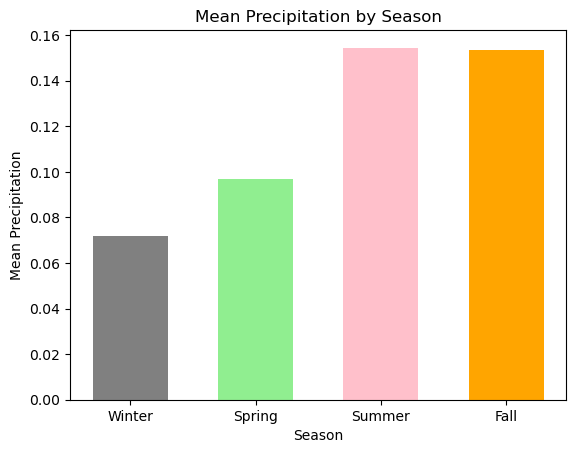

In [267]:
X = ['Winter', 'Spring', 'Summer', 'Fall']
Y = []
Y.append(df.loc[df['season'] == 0, 'Total Precipitation'].mean()) # winter
Y.append(df.loc[df['season'] == 1, 'Total Precipitation'].mean()) # spring
Y.append(df.loc[df['season'] == 2, 'Total Precipitation'].mean()) # summer
Y.append(df.loc[df['season'] == 3, 'Total Precipitation'].mean()) # fall
plt.bar(X, Y, color = ['grey', 'lightgreen', 'pink', 'orange'], width = 0.6)
 
plt.xlabel("Season")
plt.ylabel("Mean Precipitation")
plt.title("Mean Precipitation by Season")
plt.show()

The above bar graph depicts the mean precipitation levels of the 4 seasons in a calendar year. Since our dataset contained 8 seasons' worth of data (for 2 years), all of this is illustrated in the plot above.

We created a new categorical variable for season type here to determine whether there exists a relationship between seasons and the amount of rainfall.

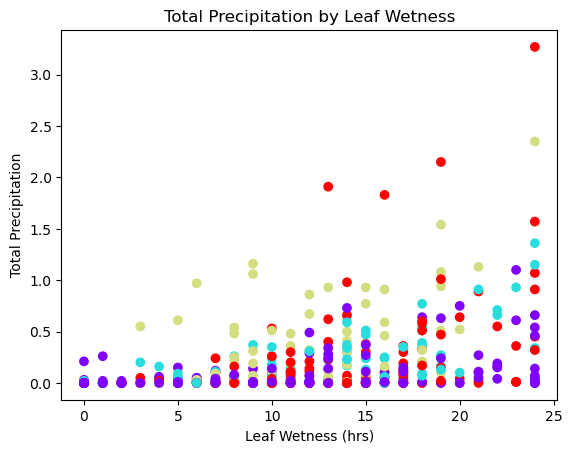

In [268]:
plt.scatter(df['Leaf Wetness (hrs)'], df['Total Precipitation'], c = df['season'], cmap = 'rainbow')
plt.xlabel("Leaf Wetness (hrs)")
plt.ylabel("Total Precipitation")
plt.title("Total Precipitation by Leaf Wetness")
plt.show()

Now, we created a scatterplot comparing the amount of hours of Leaf Wetness to Total Precipitation in a given day.

The scatterplot above shows that while there is an increasing trend throughout the range of leaf wetness values, the majority of the data points remain relatively similar throughout leaf wetness time in a day.

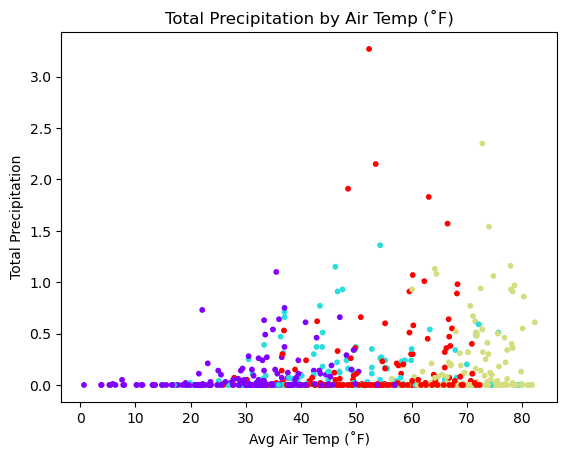

In [269]:
plt.scatter(df['Avg Air Temp (˚F)'], df['Total Precipitation'], c = df['season'], cmap = 'rainbow', s = 10)
plt.xlabel("Avg Air Temp (˚F)")
plt.ylabel("Total Precipitation")
plt.title("Total Precipitation by Air Temp (˚F)")
plt.show()

Now, we want to determine any possible trends between the average air temperature in a given day and the amount of rainfall that occurs on that day.

The scatterplot above reveals our findings. We can see here that precipitation typically peaks at an average temperature between 45 and 70 degrees Fahrenheit.

<AxesSubplot:xlabel='Relative Humidity (hrs >= 90)', ylabel='Total Precipitation'>

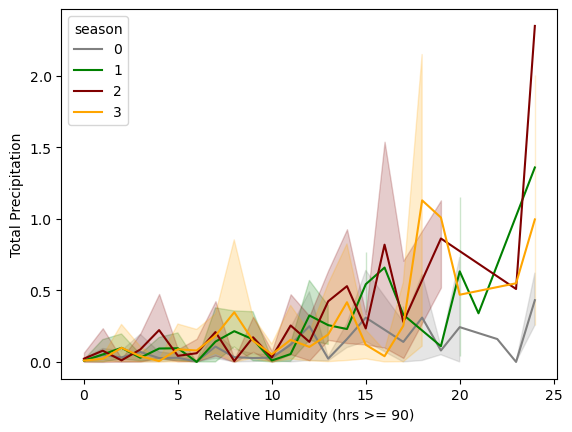

In [270]:
sns.lineplot(data=df, x = 'Relative Humidity (hrs >= 90)', y = 'Total Precipitation', hue = 'season', palette = ['grey', 'green', 'maroon', 'orange'])

Does relative humidity versus total precipitation show any trends? To answer this, we created the lineplot above.

For this lineplot, we split the data by season, with 0, 1, 2, 3 representing Winter, Spring, Summer, and Fall respectively. Except for Winter, the other 3 seasons do illustrate a generally increasing trend in precipitation level due to an increase in relative humidity.

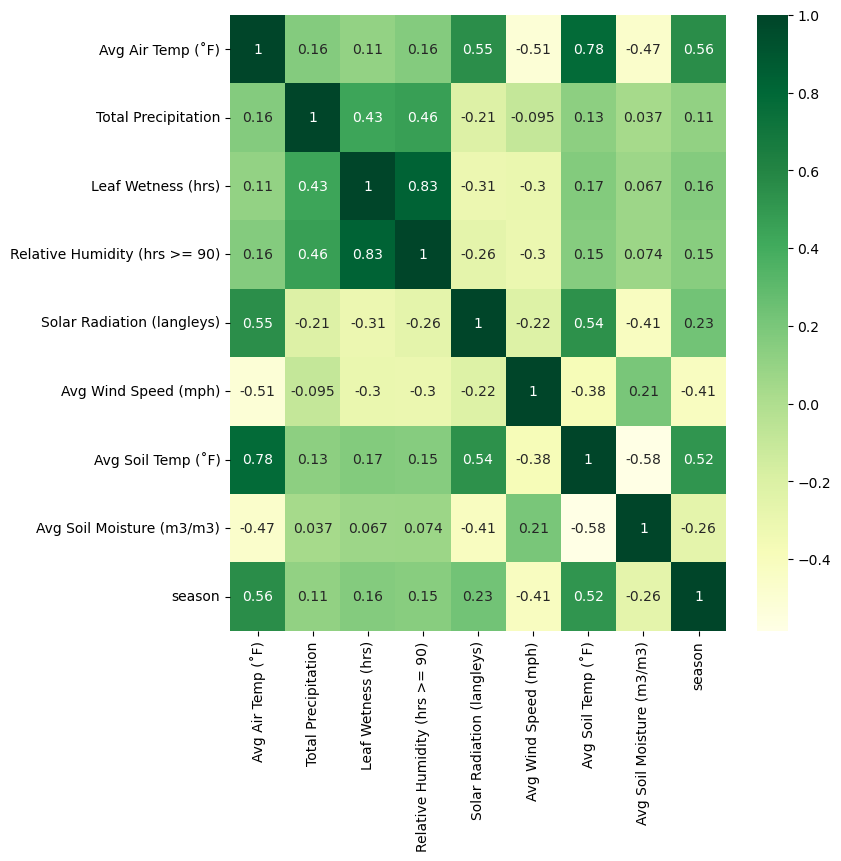

In [271]:
filtered_df = df.drop(columns=['Max Air Temp (˚F)', 'Min Air Temp (˚F)'])
corr = filtered_df.corr()
plt.subplots(figsize = (8, 8))

#Plot a heatmap of the correlation matrix we created
sns.heatmap(corr, annot = True, cmap = 'YlGn')
plt.show()

Above is a correlation matrix that we depicted as a heatmap that examines the correlation values between each quantitative feature and target variables. We removed Maximum Air Temperature and Minimum Air Temperature because Average Temperature values account for these variables here.

# Machine Learning

### Can we predict the total rain precipitation for a day?

### Logistic Regression Model

First, we will train a Logistic Regression model on our dataset:

In [272]:
model_regression = LogisticRegression()
features = df[['season','Leaf Wetness (hrs)', 'Relative Humidity (hrs >= 90)', 'Solar Radiation (langleys)', 'Avg Soil Moisture (m3/m3)']]
target = df['precipitation level']

X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size = 0.2, random_state = 99)

#Fit the model and calculate predictions for both sets (train and test)
model_regression.fit(X_train, Y_train)

model_regression_predict_train = model_regression.predict(X_train)
model_regression_predict_test = model_regression.predict(X_test)

#Print the train and test accuracies for this model
print("Train Accuracy: ", accuracy_score(Y_test, model_regression_predict_test))
print("Test Accuracy: ", accuracy_score(Y_train, model_regression_predict_train))

Train Accuracy:  0.673469387755102
Test Accuracy:  0.6455479452054794


#### Analysis
We have found that the Logistic Regression model is not a very effective of a model for our purposes and our initial research questions. The training accuracy value was approximately 67%, while the test accuracy value was about 65%.

### DecisionTreeClassifier Model

Now, let's try a Decision Tree Classifier model to see if we can better our accuracy results for our training and test sets:

In [273]:
#Create a Decision Tree Classifier model with an optimal maximum depth of 8
model_DT = tree.DecisionTreeClassifier(max_depth = 8)
features = df[['season', 'Leaf Wetness (hrs)', 'Relative Humidity (hrs >= 90)', 'Solar Radiation (langleys)']]
target = df['precipitation level']

X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size = 0.2, random_state = 99)

#Fit the model and calculate predictions for both sets (train and test)
model_DT.fit(X_train, Y_train)

model_DT_pred_train = model_DT.predict(X_train)
model_DT_pred_test = model_DT.predict(X_test)

#Print the train and test accuracies for this model
print("Train Accuracy: ", accuracy_score(Y_train, model_DT_pred_train))
print("Test Accuracy: ", accuracy_score(Y_test, model_DT_pred_test))

Train Accuracy:  0.8424657534246576
Test Accuracy:  0.6394557823129252


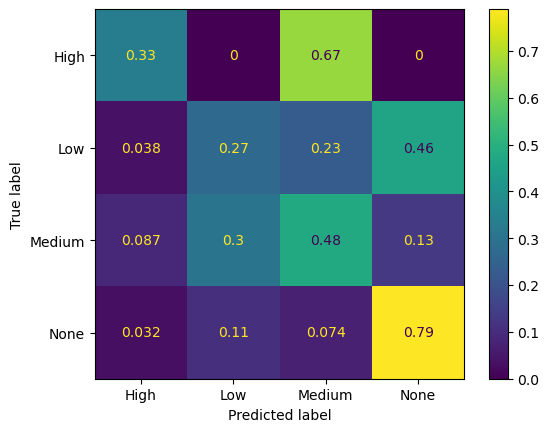

In [274]:
plot_confusion_matrix(model_DT, X_test, Y_test, normalize='true')

#### Analysis
We have found that the model using a DecisionTreeClassifier is more effective of a model for our purposes and research questions. The training accuracy value was approximately 84%, while the test accuracy value was about 63%. To get our optimal maximum depth value of 8, we tested values from 0-20 and determined which ones produced decent scores for our train and test accuracies.

We plotted the confusion matrix to show which descriptions of precipitation level we tend to correctly identify with our model. As shown in the plot, we see that 77% of the level 'None' was correctly identified by our trained model, implying that the model has a significantly efficient tendency to know when there will be no rain on a given day. For the other levels of precipitation, we see that the correctness percentages are 33%, 27%, and 30% for 'High', 'Medium', and 'Low' respectively. These percentages are lower, which could show that there is a selection bias towards the level 'None', which could result from the fact that at least half of the days in our dataset indicate no rainfall at all.

# Conclusion

All in all, we have attained considerable insight into this Cornell weather dataset. We implemented two machine learning models to train our extensive dataset on total precipitation as a categorical variable, and we performed our analyses on our hypothesis and two research questions from the beginning.

The two models we used were a Logistic Regression and a Decision Tree Classifier Model. Because the logistic regression did not provide very notable results for us (we had scoring accuracies of roughly 60% for both the training and test sets), we then implemented the Decision Tree Classifier model and found better results.

Although not perfect, our model was able to accurately predict the precipitation level for each day in our 2-year dataset reasonably. We were able to answer our initial two research questions regarding what factors influence total precipitation (using the data visualizations) and whether or not we can predict total rainfall for a day (using the two machine learning models). The results we procured demonstrated that many different variables, even somewhat unexpected ones (such as air temperature) can potentially influence total precipitation values in Ithaca.